# Niwot Ridge (NIWO) Canopy Height Change Analysis

This notebook focuses on analyzing canopy height dynamics at the Niwot Ridge (NIWO) NEON site in Colorado. Multi-year Canopy Height Model (CHM) data are used to investigate:

- **Forest Canopy Changes**: Areas of significant growth, loss, and stability are identified.  
- **Spatial Patterns**: Disturbance and regrowth across the NIWO site are visualized.  
- **Machine Learning Insights**: Methods for classifying canopy change zones are explored.

**About Niwot Ridge**

Niwot Ridge is an alpine ecology research station located approximately 65 km northwest of Denver in north-central Colorado. It lies on the Front Range of the southern Rocky Mountains, within Roosevelt National Forest, and reaches an elevation of about 2,900 meters (9,500 ft). Its high-altitude environment makes it an ideal location for studying alpine and subalpine forest dynamics, including changes in canopy height over time.<sup>[1]</sup>  

By aligning multiple CHM rasters (e.g., CHM_2023 and CHM_2019), difference maps are generated to quantify ecological changes in this alpine region. The results will contribute to a broader statewide project examining forest canopy dynamics and disturbance patterns at several NEON field sites in Colorado.

## About Niwot Ridge

- **Data Sources**:
  - NEON CHM Data (DP3.30015.001)  
  - NEON Vegetation Indices (DP3.30026.001)  
  - NEON Disturbance Logs (DP1.10111.001)

### About the NEON Canopy Height Model (CHM)

The NEON Ecosystem Structure (DP3.30015.001) data product provides a Canopy Height Model (CHM) at 1 m spatial resolution as a GeoTIFF raster. This CHM represents the estimated height of the top of the vegetation canopy above the ground immediately below it, as derived from airborne LiDAR data. Full-waveform LiDAR flights are conducted at least once per year at NEON field sites to capture high-density returns for both the vegetation surface and the underlying terrain.

Key points about this data product include:
- **Pit-Free Algorithm**: A specialized process is applied to minimize underestimation of tree-crown heights.  
- **Flight Specifications**: LiDAR is flown at 1000 m above ground level with planned 37% flight-line overlap, ensuring an average of 4 shots per square meter.  
- **Quality & Maintenance**: An annual calibration ensures vertical and horizontal accuracies are maintained, and flight-specific quality reports are included with each dataset.  

Data and detailed documentation are available via the [NEON Data Portal](https://data.neonscience.org/data-products/DP3.30015.001). Citation guidance for DP3.30015.001 is provided on the NEON website and should be followed when reusing or publishing results based on this dataset.

- **Analytical Steps**:
  1. **Data Loading & Preprocessing**: CHM rasters from different years are accessed and aligned.  
  2. **Exploratory Data Analysis**: Histograms, spatial plots, and summary statistics are generated to characterize canopy height changes.  
  3. **Classification & Modeling**: A supervised model (e.g., Random Forest) is developed to categorize patches based on growth or disturbance status.

- **Tools & Libraries**:
  - Python (rasterio, numpy, pandas, matplotlib, scikit-learn, geopandas)  
  - Jupyter Notebooks for reproducibility  
  - Git & GitHub for version control

In this notebook, these steps are demonstrated specifically for the NIWO site, contributing to the larger Colorado Canopy Change Detection project.

---

<sup>[1]</sup> Source: [Niwot Ridge - Wikipedia](https://en.wikipedia.org/wiki/Niwot_Ridge)

# Obtaining Canopy Height Model Data from NEON for Niwot Ridge

## Step 1: Querying NEON for CHM Data

This section demonstrates how data and metadata are retrieved from NEON’s public API for the Canopy Height Model (CHM) data product (DP3.30015.001) at the Niwot Ridge (NIWO) site. A query URL is constructed based on the selected site, product code, and date range (2017–2023). A request is sent to the API, and the response is parsed to collect relevant file information. The output is a CSV catalog of available GeoTIFF files, including filename, year, month, and download URLs, which can be used for subsequent data downloads and analysis.

In [1]:
import os
import requests
import pandas as pd
import numpy as np

In [2]:
# Set folder and metadata
folder_path = "C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II/NEON_NIWO_chmdata"
product_code = "DP3.30015.001"
site_code = "NIWO"
start_date = "2017-01"
end_date = "2023-12"

# API Query
query_url = (
    f"https://data.neonscience.org/api/v0/data/query?"
    f"productCode={product_code}&"
    f"siteCode={site_code}&"
    f"startDateMonth={start_date}&"
    f"endDateMonth={end_date}"
)

response = requests.get(query_url)
if response.status_code != 200:
    raise Exception(f"Failed to query NEON API: {response.status_code}")

results = response.json()

# Extract metadata from all releases/packages
metadata = []
seen = set()  # Track unique (filename, year) combinations
releases = results.get("data", {}).get("releases", [])

for release in releases:
    for package in release.get("packages", []):
        month_tag = package.get("month", "Unknown")  # Format: "YYYY-MM"
        if "-" in month_tag:
            year, month = month_tag.split("-")
        else:
            year, month = "Unknown", "Unknown"

        for file in package.get("files", []):
            name = file["name"]
            url = file["url"]

            # Only work with GeoTIFF files
            if name.endswith(".tif"):
                key = (name, year)
                if key in seen:
                    continue
                seen.add(key)

                metadata.append({
                    "filename": name,
                    "year": int(year),
                    "month": int(month),
                    "url": url
                })

# Convert to DataFrame
metadata_df = pd.DataFrame(metadata)

# Sort by year/month then filename
metadata_df = metadata_df.sort_values(by=["year", "month", "filename"], ascending=[True, True, True])

# Save metadata to CSV
csv_path = os.path.join(folder_path, "NIWO_chm_file_catalog.csv")
metadata_df.to_csv(csv_path, index=False)

print(f"✅ Metadata CSV saved to: {csv_path}")

✅ Metadata CSV saved to: C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II/NEON_NIWO_chmdata\NIWO_chm_file_catalog.csv


## Step 2: Downloading CHM TIFF Files

In this section, the CSV catalog generated previously is used to download Canopy Height Model (CHM) GeoTIFFs from NEON’s data portal. Each file is saved into a subfolder corresponding to its data year. The process checks whether a local copy exists before making a request, which avoids redundant downloads. A simple summary shows how many files were successfully retrieved for each year.

In [10]:
from collections import defaultdict

# Load catalog CSV
catalog_path = 'C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II/NEON_NIWO_chmdata/NIWO_chm_file_catalog.csv'
catalog_df = pd.read_csv(catalog_path)

# Base directory to save files
base_dir = 'C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II/NEON_NIWO_chmdata'

# Create directories by year and download files
download_counts = defaultdict(int)

for _, row in catalog_df.iterrows():
    year = str(row["year"])
    filename = row["filename"]
    url = row["url"]
    
    # Directory for that year
    year_dir = os.path.join(base_dir, year)
    os.makedirs(year_dir, exist_ok=True)
    
    save_path = os.path.join(year_dir, filename)
    
    # Download only if file does not already exist
    if not os.path.exists(save_path):
        try:
            r = requests.get(url, stream=True)
            r.raise_for_status()
            with open(save_path, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
            download_counts[year] += 1
        except Exception as e:
            print(f"❌ Failed to download {filename}: {e}")

# Summary output
print("\n✅ Download Summary:")
if download_counts:
    for year, count in sorted(download_counts.items()):
        print(f"  {year}: {count} file(s) downloaded")
else:
    print("  All files already present; no downloads were needed.")


✅ Download Summary:
  2017: 204 file(s) downloaded
  2018: 171 file(s) downloaded
  2019: 172 file(s) downloaded
  2020: 165 file(s) downloaded
  2023: 171 file(s) downloaded


## Step 3: CHM Raster Inspection and Summary Statistics

This section examines each Canopy Height Model (CHM) GeoTIFF to verify data integrity and gather basic statistics. The code traverses all year-specific subfolders, loads each CHM tile, and computes:

- **Raster Dimensions** (width, height, total number of pixels)
- **Valid Pixel Counts** (total pixels minus those assigned as no-data)
- **No-Data Statistics** (count of no-data pixels, percentage of valid area)
- **Height Metrics** (minimum, maximum, mean, standard deviation)

By calculating these values, potential issues such as incomplete tiles or suspicious canopy heights (e.g., negative or extremely large values) can be quickly identified. For instance, a tile with a high fraction of no-data pixels might indicate partial coverage or flight limitations. These summary tables also help confirm that multiple years’ data are consistent in resolution, spatial extent, and coordinate reference system (CRS) before proceeding with change detection or modeling. The resulting CSV file facilitates easy filtering and comparisons across all tiles and years.

In [3]:
import glob
import rasterio
from rasterio.plot import show
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm  # Progress bar

In [29]:
tif_path = "C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II/NEON_NIWO_chmdata/2017/NEON_D13_NIWO_DP3_443000_4428000_CHM.tif"
with rasterio.open(tif_path) as src:
    meta = src.meta
    print("Meta (Dictionary):", meta)

Meta (Dictionary): {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 1000, 'height': 1000, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 13N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32613"]]'), 'transform': Affine(1.0, 0.0, 443000.0,
       0.0, -1.0, 4429000.0)}


In [17]:
base_dir = "C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II/NEON_NIWO_chmdata"

summary_records = []

# 1) Gather all TIFF files across all year folders
all_tif_files = []
year_folders = sorted(
    d for d in glob.glob(os.path.join(base_dir, "*")) if os.path.isdir(d)
)

for folder in year_folders:
    tif_files = glob.glob(os.path.join(folder, "*.tif"))
    all_tif_files.extend(tif_files)

# 2) Single progress bar over the entire list of TIFFs
for tif_path in tqdm(all_tif_files, desc="Analyzing CHM TIFFs"):
    with rasterio.open(tif_path) as src:
        meta = src.meta
        data = src.read(1)

        # Total pixels
        total_pixels = meta["width"] * meta["height"]
        
        # Mask out the no-data value
        data_masked = np.ma.masked_equal(data, meta.get("nodata", -9999))
        valid_pixels = data_masked.count()
        nodata_pixels = total_pixels - valid_pixels

        # Compute % valid
        valid_fraction = valid_pixels / total_pixels if total_pixels > 0 else 0
        valid_percent = valid_fraction * 100

        year = os.path.basename(os.path.dirname(tif_path))  # the subfolder name
        filename = os.path.basename(tif_path)

        summary_records.append({
            "year": os.path.basename(os.path.dirname(tif_path)),
            "filename": os.path.basename(tif_path),
            "driver": meta["driver"],
            "dtype": meta["dtype"],
            "nodata_value": meta.get("nodata", -9999),
            "width": meta["width"],
            "height": meta["height"],
            "count_bands": meta["count"],
            "crs": str(meta["crs"]),
            "transform": str(meta["transform"]),
            "total_pixels": total_pixels,
            "valid_pixels": valid_pixels,
            "nodata_pixels": nodata_pixels,
            "pct_valid_pixels": valid_percent,
            "min_height": data_masked.min(),
            "max_height": data_masked.max(),
            "mean_height": data_masked.mean(),
            "std_height": data_masked.std()
        })

# Store in a DataFrame
summary_df = pd.DataFrame(summary_records)
summary_df = summary_df.sort_values(by=["year", "filename"], ascending=[True, True])

summary_csv = os.path.join(base_dir, "CHM_summary_stats.csv")
summary_df.to_csv(summary_csv, index=False)

print("Summary statistics saved to:", summary_csv)

Analyzing CHM TIFFs: 100%|██████████| 1/1 [00:05<00:00,  5.02s/it]

Summary statistics saved to: C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II/NEON_NIWO_chmdata\CHM_summary_stats.csv


In [36]:
summary_df.head()

,year,filename,driver,dtype,nodata_value,width,height,count_bands,crs,transform,total_pixels,valid_pixels,nodata_pixels,pct_valid_pixels,min_height,max_height,mean_height,std_height
0,2017,NEON_D13_NIWO_DP3_443000_4428000_CHM.tif,GTiff,float32,-9999.0,1000,1000,1,EPSG:32613,"| 1.00, 0.00, 443000.00|\n| 0.00,-1.00, 442900...",1000000,60994,939006,6.0994,0.0,26.378000,2.711066,5.011453
1,2017,NEON_D13_NIWO_DP3_443000_4433000_CHM.tif,GTiff,float32,-9999.0,1000,1000,1,EPSG:32613,"| 1.00, 0.00, 443000.00|\n| 0.00,-1.00, 443400...",1000000,111,999889,0.0111,0.0,0.000000,0.000000,0.000000
2,2017,NEON_D13_NIWO_DP3_443000_4436000_CHM.tif,GTiff,float32,-9999.0,1000,1000,1,EPSG:32613,"| 1.00, 0.00, 443000.00|\n| 0.00,-1.00, 443700...",1000000,3405,996595,0.3405,0.0,24.566000,1.003224,3.010736
3,2017,NEON_D13_NIWO_DP3_443000_4437000_CHM.tif,GTiff,float32,-9999.0,1000,1000,1,EPSG:32613,"| 1.00, 0.00, 443000.00|\n| 0.00,-1.00, 443800...",1000000,23782,976218,2.3782,0.0,28.434999,1.118840,3.540176
4,2017,NEON_D13_NIWO_DP3_443000_4438000_CHM.tif,GTiff,float32,-9999.0,1000,1000,1,EPSG:32613,"| 1.00, 0.00, 443000.00|\n| 0.00,-1.00, 443900...",1000000,5908,994092,0.5908,0.0,64.071999,3.297372,12.172543


In [4]:
summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         883 non-null    object 
 1   filename     883 non-null    object 
 2   width        883 non-null    int64  
 3   height       883 non-null    int64  
 4   crs          883 non-null    object 
 5   min_height   883 non-null    float64
 6   max_height   883 non-null    float64
 7   mean_height  883 non-null    float64
 8   std_dev      883 non-null    float64
dtypes: float64(4), int64(2), object(3)
memory usage: 62.2+ KB


In [74]:
# Group by year, then compute aggregates of interest
year_stats = summary_df.groupby("year").agg({
    "mean_height": ["mean", "std", "min", "max"],
    "pct_valid_pixels": "mean",
    "filename": "count"
})

# Tidy up column names
year_stats.columns = [
    "avg_tile_mean_height", "mean_height_std", "mean_height_min", "mean_height_max",
    "avg_pct_valid_pixels", "file_count"
]

year_stats.reset_index(inplace=True)
year_stats

,year,avg_tile_mean_height,mean_height_std,mean_height_min,mean_height_max,avg_pct_valid_pixels,file_count
0,2017,3.560610,2.546588,0.000000,8.916342,81.114601,204
1,2018,4.466115,2.751445,0.002565,9.694996,86.731901,171
2,2019,4.504431,2.823123,0.000000,9.769005,86.128994,172
3,2020,3.941819,2.535517,0.000000,9.046358,80.752905,165
4,2023,4.591746,2.834019,0.002592,10.011965,87.112870,171


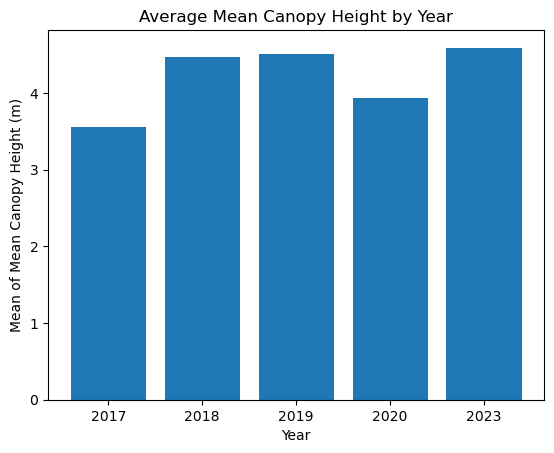

In [56]:
plt.bar(year_stats["year"], year_stats["mean_height_mean"])
plt.xlabel("Year")
plt.ylabel("Mean of Mean Canopy Height (m)")
plt.title("Average Mean Canopy Height by Year")
plt.show()

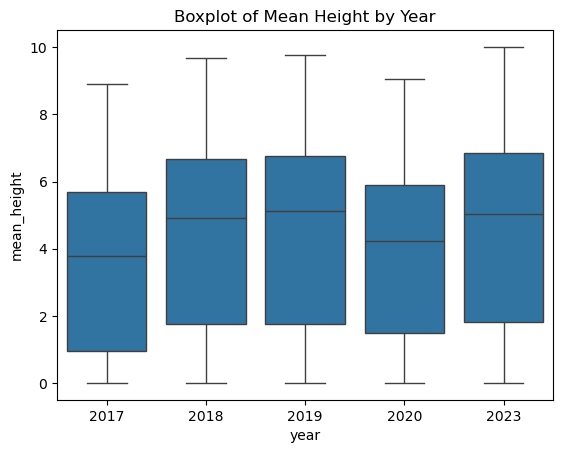

In [72]:
sns.boxplot(data=summary_df, x="year", y="mean_height")
plt.title("Boxplot of Mean Height by Year")
plt.show()

### Preliminary Observations

Below are some initial takeaways from the tile-level metrics across different years. 

1. **Increasing Mean Tile Height?**  
   - The average tile mean height shows an overall increase from ~3.56 m in 2017 to ~4.59 m in 2023.  
   - This rise might indicate genuine canopy growth over time, though other factors (flight coverage, leaf-on vs. leaf-off timing, sensor parameters) also influence observed heights.

2. **Variability Across Years**  
   - Each year’s tile-level heights exhibit a notable spread (standard deviations around 2.5–2.8 m). Some tiles represent open or sparse vegetation; others contain taller stands.  
   - In 2020, for instance, the drop to ~3.94 m average could reflect real changes on the ground, differences in LiDAR sampling, or some disturbance events.

3. **Data Coverage**  
   - The fraction of valid (non-no-data) pixels also differs by year (about 80–87%). Better LiDAR returns in some years can lead to higher average canopy heights and fewer -9999 patches.

4. **Next Steps**  
   - **Spatial Change Analysis**: Construct difference maps (e.g., 2023 minus 2017) to pinpoint localized gains or losses in canopy height.  
   - **Investigate Local Conditions**: Check NEON disturbance logs to confirm whether changes are ecological (forest growth, disturbance) or related to flight conditions.  
   - **Statistical Tests**: Conduct more formal analyses (e.g., ANOVA) to see if changes are statistically significant across years.


# Creating Yearly Mosaics for NEON CHM Tiles

The following steps are performed to combine multiple 1 km² CHM tiles into a single mosaic for each available year:

1. **Years Identified**  
   CHM data from 2017-2023 is available for the NIWO region.

2. **Tiles Located**  
   All `.tif` files associated with a given year are found within that year’s folder.

3. **Tile Merging**  
   The `merge()` function from Rasterio is then applied to unify the input tiles into a single array.  
   - All input tiles are assumed to share consistent coordinate reference system, resolution, and nodata settings.

4. **Metadata Updated and Mosaic Written**  
   The metadata is adapted (e.g., new height, width, transform), and each merged mosaic is saved as `CHM_{year}_mosaic.tif`.

By the end, we’ll have one GeoTIFF mosaic per year. This approach has the advantage simplifying subsequent operations—such as alignment checks, difference calculations, or summary statistics—because we only deal with one file per year instead of many individual tiles.

In [19]:
from rasterio.merge import merge

# Suppose we have a list of years
years = [2017, 2018, 2019, 2020, 2023]

# Base directory with subfolders named "2017_tiles", "2018_tiles", etc.
base_dir = r"C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\NEON_NIWO_chmdata\data"
out_dir = r"C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\NEON_NIWO_chmdata\data\mosaics"

# Outer loop over years (show progress for year-by-year)
for year in tqdm(years, desc="Processing each year"):
    # Build input folder and output mosaic path
    year_folder = os.path.join(base_dir, f"{year}")
    out_mosaic_path = os.path.join(out_dir, f"CHM_{year}_mosaic.tif")

    # Find all TIFFs in the year folder
    tif_list = glob.glob(os.path.join(year_folder, "*.tif"))
    if not tif_list:
        print(f"No tiles found for {year} in {year_folder}. Skipping.")
        continue

    # We'll store rasterio datasets in a list
    src_files_to_mosaic = []

    # Inner loop: use tqdm to show reading-progress for each tile
    for fp in tqdm(tif_list, desc=f"Reading tiles for {year}", leave=False):
        src = rasterio.open(fp)
        src_files_to_mosaic.append(src)

    # Merge them into a single mosaic array
    mosaic_arr, mosaic_trans = merge(src_files_to_mosaic)

    # Copy metadata from the first tile
    out_meta = src_files_to_mosaic[0].meta.copy()
    out_meta.update({
        "height": mosaic_arr.shape[1],
        "width": mosaic_arr.shape[2],
        "transform": mosaic_trans,
        "nodata": -9999.0  # unify no-data across mosaic
        # optionally "dtype": "float32" if needed
    })

    # Write out mosaic
    with rasterio.open(out_mosaic_path, "w", **out_meta) as dst:
        dst.write(mosaic_arr)

    # Close each dataset
    for src in src_files_to_mosaic:
        src.close()

    print(f"✅ Mosaic for {year} saved to: {out_mosaic_path}")

Processing each year:  20%|██        | 1/5 [00:04<00:17,  4.34s/it]       

✅ Mosaic for 2017 saved to: C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\NEON_NIWO_chmdata\data\mosaics\CHM_2017_mosaic.tif



Processing each year:  40%|████      | 2/5 [00:09<00:14,  4.84s/it]       

✅ Mosaic for 2018 saved to: C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\NEON_NIWO_chmdata\data\mosaics\CHM_2018_mosaic.tif



Processing each year:  60%|██████    | 3/5 [00:15<00:10,  5.13s/it]      

✅ Mosaic for 2019 saved to: C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\NEON_NIWO_chmdata\data\mosaics\CHM_2019_mosaic.tif



Processing each year:  80%|████████  | 4/5 [00:20<00:05,  5.12s/it]       

✅ Mosaic for 2020 saved to: C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\NEON_NIWO_chmdata\data\mosaics\CHM_2020_mosaic.tif



Processing each year: 100%|██████████| 5/5 [00:25<00:00,  5.11s/it]       

✅ Mosaic for 2023 saved to: C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\NEON_NIWO_chmdata\data\mosaics\CHM_2023_mosaic.tif


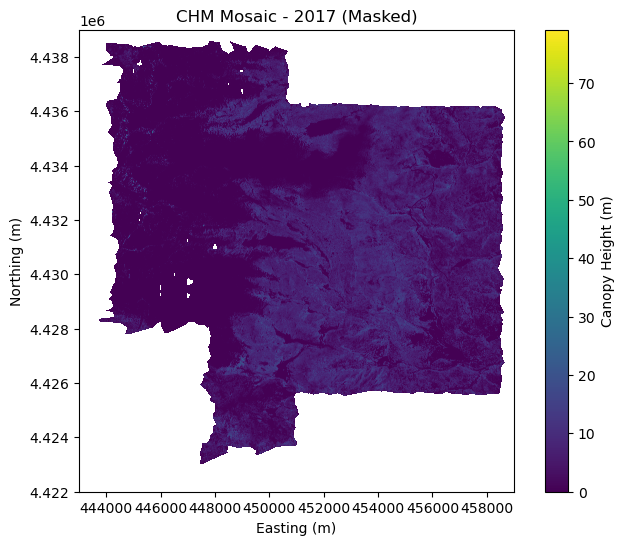

In [25]:
from rasterio.plot import plotting_extent

mosaic_path = r"C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\NEON_NIWO_chmdata\data\mosaics\CHM_2017_mosaic.tif"

with rasterio.open(mosaic_path) as src:
    chm_data = src.read(1)
    extent = plotting_extent(src)

# Replace -9999 with np.nan so that matplotlib ignores them
chm_data = np.where(chm_data == -9999, np.nan, chm_data)

plt.figure(figsize=(8, 6))
plt.title("CHM Mosaic - 2017 (Masked)")

# Now the nodata pixels are NaN, so they won't affect the color range
im = plt.imshow(chm_data, extent=extent, cmap="viridis", origin="upper")

cbar = plt.colorbar(im)
cbar.set_label("Canopy Height (m)")

plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.show()

In [29]:
# Flatten the mosaic data into a 1D array
all_values = chm_data.flatten()
total_pixels = all_values.size

# Count nodata pixels (value -9999)
nodata_count = np.sum(all_values == -9999)

# Compute valid pixels and their percentage
valid_count = total_pixels - nodata_count
valid_percentage = (valid_count / total_pixels) * 100

print(f"Total pixels: {total_pixels}")
print(f"Number of nodata pixels: {nodata_count}")
print(f"Number of valid pixels: {valid_count}")
print(f"Percentage of valid pixels: {valid_percentage:.2f}%")

# Replace -9999 with np.nan to exclude them from min/max
valid_values = np.where(all_values == -9999, np.nan, all_values)
print("Valid min:", np.nanmin(valid_values))
print("Valid max:", np.nanmax(valid_values))
print("Mean canopy height:", np.nanmean(valid_values))

Total pixels: 272000000
Number of nodata pixels: 0
Number of valid pixels: 272000000
Percentage of valid pixels: 100.00%
Valid min: 0.0
Valid max: 79.133
Mean canopy height: 3.6455364


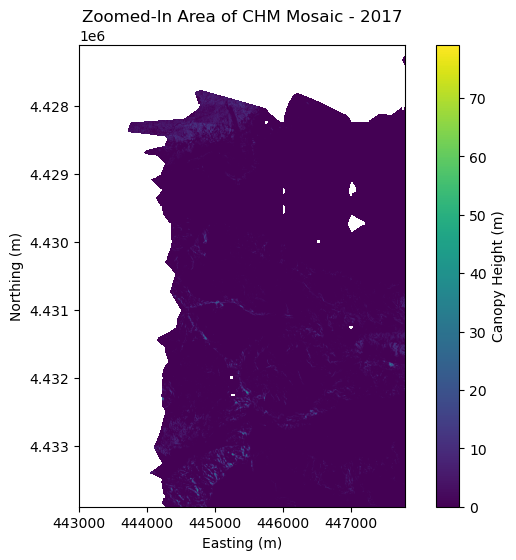

In [30]:
# Load the mosaic
mosaic_path = r"C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\NEON_NIWO_chmdata\data\mosaics\CHM_2017_mosaic.tif"
with rasterio.open(mosaic_path) as src:
    chm_data = src.read(1)  # Read the first band
    extent = plotting_extent(src)  # Get the spatial extent

# Mask out nodata values (-9999) by replacing them with np.nan
chm_data = np.where(chm_data == -9999, np.nan, chm_data)

# Define the full extent: [left, right, bottom, top]
left, right, bottom, top = extent

# Example zoom: focus on the western 30% of the mosaic
zoom_left = left
zoom_right = left + 0.3 * (right - left)
# For the vertical range, choose a sub-region; adjust these values as needed
zoom_bottom = bottom + 0.3 * (top - bottom)
zoom_top = bottom + 0.7* (top - bottom)

plt.figure(figsize=(8, 6))
plt.title("Zoomed-In Area of CHM Mosaic - 2017")

# Plot the full mosaic
im = plt.imshow(chm_data, extent=extent, cmap="viridis", origin="upper")
# Adjust the plot limits to zoom into the selected area
plt.xlim(zoom_left, zoom_right)
plt.ylim(zoom_top, zoom_bottom)  # Note: origin='upper' means y-values decrease upward

# Add a colorbar to interpret the canopy height values
cbar = plt.colorbar(im)
cbar.set_label("Canopy Height (m)")

plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.show()

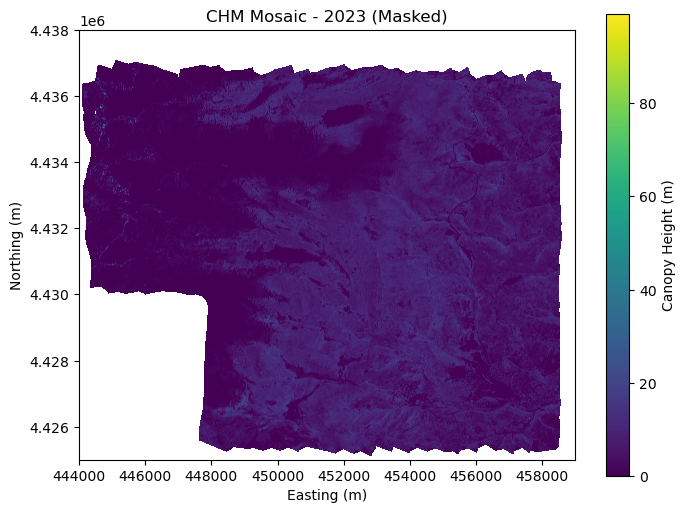

In [31]:
from rasterio.plot import plotting_extent

mosaic_path = r"C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\NEON_NIWO_chmdata\data\mosaics\CHM_2023_mosaic.tif"

with rasterio.open(mosaic_path) as src:
    chm_data = src.read(1)
    extent = plotting_extent(src)

# Replace -9999 with np.nan so that matplotlib ignores them
chm_data = np.where(chm_data == -9999, np.nan, chm_data)

plt.figure(figsize=(8, 6))
plt.title("CHM Mosaic - 2023 (Masked)")

# Now the nodata pixels are NaN, so they won't affect the color range
im = plt.imshow(chm_data, extent=extent, cmap="viridis", origin="upper")

cbar = plt.colorbar(im)
cbar.set_label("Canopy Height (m)")

plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.show()

**Note on the Masked CHM Mosaic Plot**

- **Nodata Masking**: By converting `-9999` values to `NaN`, nodata pixels are excluded from the color scale. 
- **Coordinate Axes**: 
  - **Easting (m)** represents the horizontal axis in meters within the UTM coordinate system.  
  - **Northing (m)** is the vertical axis, also in meters under UTM. 
  Together, they define the georeferenced location of each pixel.
- **Overall Appearance**: Areas with visible patterns indicate regions of varying vegetation height, while any fully transparent or white areas (if present) represent masked nodata pixels. 

### Alignment of Yearly Mosaics to a Common Reference Grid

To ensure spatial consistency for time-series analysis, the 2017 mosaic was selected as the common reference grid. The earliest available dataset was chosen so that changes can be compared consistently over time. 

For each subsequent year, the following procedure is applied:
- The mosaic is opened and its spatial properties (coordinate reference system, transform, width, and height) are compared to those of the 2017 reference.
- If any differences are detected, the mosaic is reprojected and resampled to match the 2017 grid using bilinear resampling.
- If the spatial properties already match, no further processing is needed.

This alignment step ensures that pixel-by-pixel comparisons, such as difference maps or trend analyses, can be performed reliably across years.

In [34]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Define the reference mosaic (e.g., from 2017)
reference_year = 2017
reference_mosaic_path = r"C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\NEON_NIWO_chmdata\data\mosaics\CHM_2017_mosaic.tif"

# List the years that you want to align
years = [2017, 2018, 2019, 2020, 2023]

# Create an output folder for aligned mosaics
aligned_folder = r"C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\NEON_NIWO_chmdata\data\mosaics\aligned_mosaics"
os.makedirs(aligned_folder, exist_ok=True)

# Open the reference mosaic and save its grid parameters
with rasterio.open(reference_mosaic_path) as src_ref:
    ref_transform = src_ref.transform
    ref_crs = src_ref.crs
    ref_width = src_ref.width
    ref_height = src_ref.height
    ref_meta = src_ref.meta.copy()

# Loop over each year and align the mosaic to the reference grid
for year in tqdm(years, desc="Aligning mosaics"):
    mosaic_path = r"C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\NEON_NIWO_chmdata\data\mosaics\CHM_{}_mosaic.tif".format(year)
    aligned_path = os.path.join(aligned_folder, f"CHM_{year}_mosaic_aligned.tif")
    
    # If the mosaic is the reference, copy it directly to the aligned folder
    if year == reference_year:
        if mosaic_path != aligned_path:
            os.system(f'copy "{mosaic_path}" "{aligned_path}"')
        continue
    
    with rasterio.open(mosaic_path) as src:
        # Check if the mosaic already matches the reference grid
        if (src.transform != ref_transform) or (src.crs != ref_crs) or (src.width != ref_width) or (src.height != ref_height):
            # Compute a new transform and dimensions to reproject the mosaic
            transform, width, height = calculate_default_transform(
                src.crs, ref_crs, src.width, src.height, *src.bounds
            )
            new_meta = ref_meta.copy()
            new_meta.update({
                "transform": transform,
                "width": width,
                "height": height,
                "nodata": -9999
            })
            
            # Reproject and write out the aligned mosaic, with progress on each band
            with rasterio.open(aligned_path, "w", **new_meta) as dst:
                for i in tqdm(range(1, src.count + 1), desc=f"Reprojecting bands for {year}", leave=False):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=ref_crs,
                        resampling=Resampling.bilinear
                    )
        else:
            # If the mosaic is already aligned, copy it to the aligned folder
            os.system(f'copy "{mosaic_path}" "{aligned_path}"')
            
print("Alignment complete!")

Aligning mosaics: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]           

Alignment complete!


### Generation of Canopy Height Difference Map

In this step, a difference map is produced to quantify canopy height changes between 2023 and 2017. The process is as follows:

- **Data Extraction**: The CHM mosaics for 2017 and 2023 are read as floating-point arrays.
- **Handling No-Data Values**: No-data values (e.g., -9999) are identified in each mosaic. A combined mask is created to flag pixels that are invalid in either dataset.
- **Difference Calculation**: The 2017 values are subtracted from the 2023 values on a pixel-by-pixel basis. Pixels flagged as invalid are assigned the no-data value.
- **Output Generation**: The resulting difference mosaic is saved as a GeoTIFF file. This map will serve as the basis for analyzing areas of canopy gain and loss.

The resulting difference map will be used for further spatial change analysis.

In [36]:
from rasterio.windows import from_bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Set file paths for the mosaics and output difference mosaic
mosaic2017_path = r"C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\NEON_NIWO_chmdata\data\mosaics\aligned_mosaics\CHM_2017_mosaic_aligned.tif"
mosaic2023_path = r"C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\NEON_NIWO_chmdata\data\mosaics\aligned_mosaics\CHM_2023_mosaic_aligned.tif"
diff_path = r"C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\NEON_NIWO_chmdata\data\mosaics\CHM_diff_2023_minus_2017.tif"

# Open both mosaics and compute the overlapping area
with rasterio.open(mosaic2017_path) as src2017, \
     rasterio.open(mosaic2023_path) as src2023:
    
    # Get bounds of each mosaic
    bounds_2017 = src2017.bounds
    bounds_2023 = src2023.bounds
    
    # Compute the intersection (overlap) of the two bounds
    inter_left = max(bounds_2017.left, bounds_2023.left)
    inter_right = min(bounds_2017.right, bounds_2023.right)
    inter_bottom = max(bounds_2017.bottom, bounds_2023.bottom)
    inter_top = min(bounds_2017.top, bounds_2023.top)
    
    # Check if there is an overlap
    if inter_left >= inter_right or inter_bottom >= inter_top:
        raise ValueError("No overlapping area found between the two mosaics.")
    
    intersection_bounds = (inter_left, inter_bottom, inter_right, inter_top)
    
    # Create windows for the overlapping area using each mosaic's transform
    window_2017 = from_bounds(*intersection_bounds, transform=src2017.transform)
    window_2023 = from_bounds(*intersection_bounds, transform=src2023.transform)
    
    # Read the data from the overlapping windows
    chm2017 = src2017.read(1, window=window_2017).astype("float32")
    chm2023 = src2023.read(1, window=window_2023).astype("float32")
    
    # Verify both arrays have the same shape
    print("Shape of 2017 data:", chm2017.shape)
    print("Shape of 2023 data:", chm2023.shape)
    
    # Define nodata values
    nodata2017 = src2017.nodata if src2017.nodata is not None else -9999.0
    nodata2023 = src2023.nodata if src2023.nodata is not None else -9999.0
    
    # Create masks for nodata pixels
    invalid_2017 = (chm2017 == nodata2017)
    invalid_2023 = (chm2023 == nodata2023)
    combined_invalid = invalid_2017 | invalid_2023
    
    # Compute the difference (2023 minus 2017)
    diff_data = chm2023 - chm2017
    
    # Set the difference to nodata where either mosaic was nodata
    diff_data[combined_invalid] = -9999.0
    
    # Prepare metadata for the output file
    diff_meta = src2017.meta.copy()
    diff_meta.update({
        "height": chm2017.shape[0],
        "width": chm2017.shape[1],
        "transform": rasterio.windows.transform(window_2017, src2017.transform),
        "dtype": "float32",
        "nodata": -9999.0
    })

# Write the difference mosaic to disk
with rasterio.open(diff_path, "w", **diff_meta) as dst:
    dst.write(diff_data, 1)

print(f"Difference mosaic saved at: {diff_path}")

Shape of 2017 data: (13000, 15000)
Shape of 2023 data: (13000, 15000)
Difference mosaic saved at: C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\NEON_NIWO_chmdata\data\mosaics\CHM_diff_2023_minus_2017.tif


### Difference Map Visualization

The following code visualizes the difference map (2023 minus 2017) by using a two-slope normalization to center the colormap at zero. In this process, nodata values (represented by -9999) are replaced with NaN so that they do not affect the display or statistical calculations. The 2nd and 98th percentiles of valid difference values are used to clip the display range, ensuring that both canopy loss and gain are clearly distinguished. The plot is annotated with appropriate axis labels (Easting and Northing in meters) and a colorbar showing the canopy height differences in meters.

Using display limits: lower=-2.49, upper=5.39


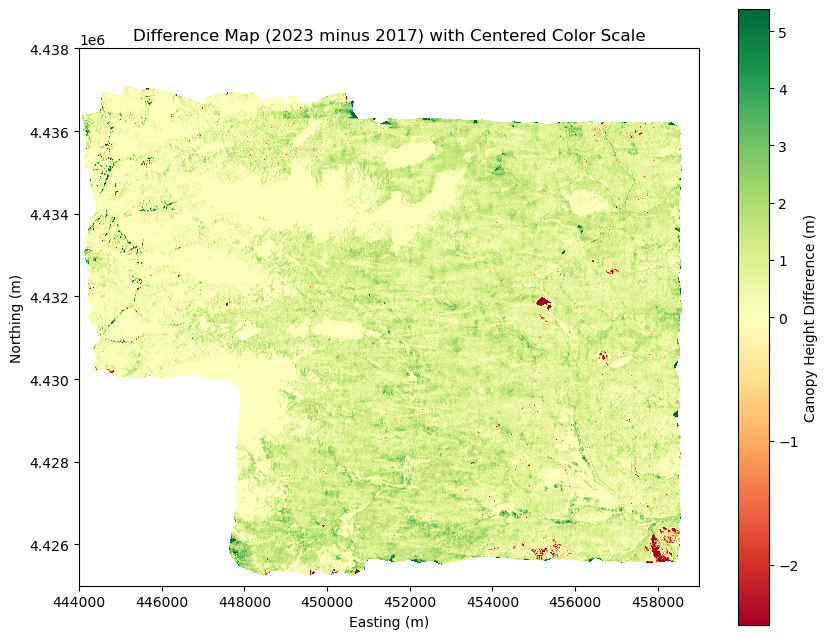

In [38]:
from rasterio.plot import plotting_extent
import matplotlib.colors as colors
from scipy.ndimage import label

# Open the difference mosaic and get the data and its spatial extent
with rasterio.open(diff_path) as src:
    diff_data = src.read(1)  # Read the first band
    extent = plotting_extent(src)  # Get the extent for plotting

# Replace the nodata values (-9999) with NaN so they are ignored in display and statistics
diff_data_vis = np.where(diff_data == -9999, np.nan, diff_data)

# Compute valid difference values and derive percentiles for clipping
valid_vals = diff_data_vis[np.isfinite(diff_data_vis)]
lower, upper = np.percentile(valid_vals, [2, 98])
print(f"Using display limits: lower={lower:.2f}, upper={upper:.2f}")

# Create a TwoSlopeNorm normalization centered at 0, so that zero change appears as a neutral color
norm = colors.TwoSlopeNorm(vmin=lower, vcenter=0, vmax=upper)

# Plot the difference mosaic using the normalized color scale
plt.figure(figsize=(10, 8))
plt.imshow(diff_data_vis, extent=extent, cmap="RdYlGn", origin="upper", norm=norm)
plt.title("Difference Map (2023 minus 2017) with Centered Color Scale")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
cbar = plt.colorbar()
cbar.set_label("Canopy Height Difference (m)")
plt.show()

### Compute Summary Stats

The difference map shows a wide range of canopy height changes (from –70.26 m to 89.92 m) with an average net gain of 0.77 m. The standard deviation of 1.90 m indicates significant spatial variability that warrants further localized investigation.

In [40]:
# Extract valid pixels (ignoring nodata)
valid_diff = diff_data[diff_data != -9999]
print("Summary statistics for the difference map:")
print(f"  Min: {np.nanmin(valid_diff):.2f} m")
print(f"  Max: {np.nanmax(valid_diff):.2f} m")
print(f"  Mean: {np.nanmean(valid_diff):.2f} m")
print(f"  Standard Deviation: {np.nanstd(valid_diff):.2f} m")

Summary statistics for the difference map:
  Min: -70.26 m
  Max: 89.92 m
  Mean: 0.77 m
  Standard Deviation: 1.90 m


### Canopy Change Classification

The difference map (2023 minus 2017) is used to classify canopy change into three categories:
- **Loss**: Pixels with a change of less than –1 m.
- **Stable**: Pixels with a change between –1 m and 1 m (inclusive).
- **Gain**: Pixels with a change greater than 1 m.

Only valid pixels (those not equal to the nodata value of –9999) are processed. The classified map is then visualized with a discrete colormap to clearly show regions of canopy loss, stability, and gain.

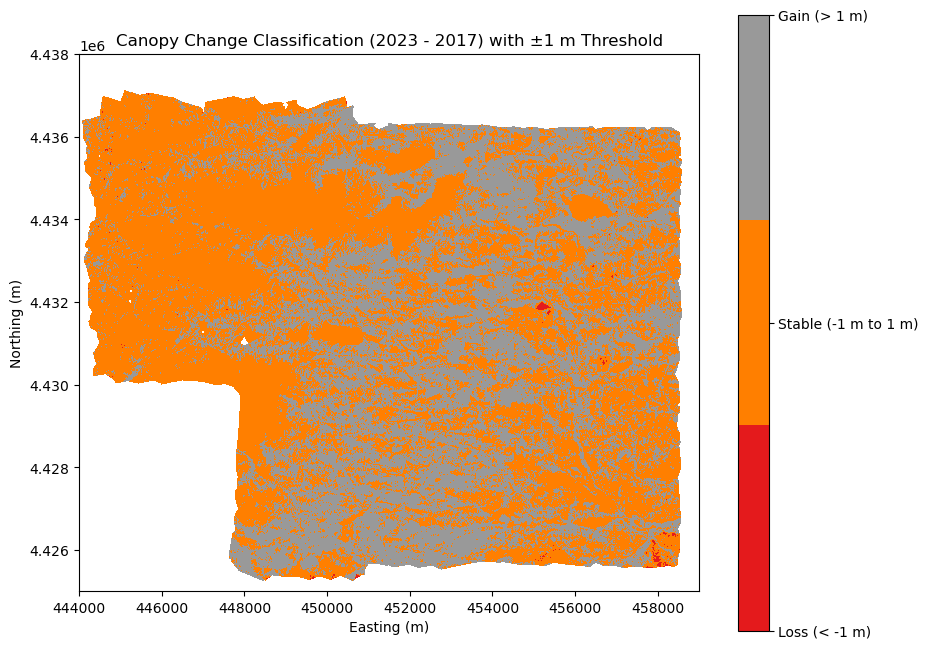

In [42]:
# Define thresholds for change classification:
#   Loss: difference < -1 m
#   Stable: between -1 and 1 m (inclusive)
#   Gain: difference > 1 m
change_class = np.full(diff_data.shape, np.nan)

# Only process valid pixels (diff_data != -9999)
mask_valid = diff_data != -9999

change_class[mask_valid & (diff_data < -1)] = 0   # Canopy loss
change_class[mask_valid & (diff_data >= -1) & (diff_data <= 1)] = 1  # Stable canopy
change_class[mask_valid & (diff_data > 1)] = 2   # Canopy gain

# Visualize the classified change map
plt.figure(figsize=(10, 8))
# Use a discrete colormap with 3 classes
cmap = plt.get_cmap("Set1", 3)
im = plt.imshow(change_class, extent=extent, cmap=cmap, origin="upper")
plt.title("Canopy Change Classification (2023 - 2017) with ±1 m Threshold")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
cbar = plt.colorbar(im, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(["Loss (< -1 m)", "Stable (-1 m to 1 m)", "Gain (> 1 m)"])
plt.show()

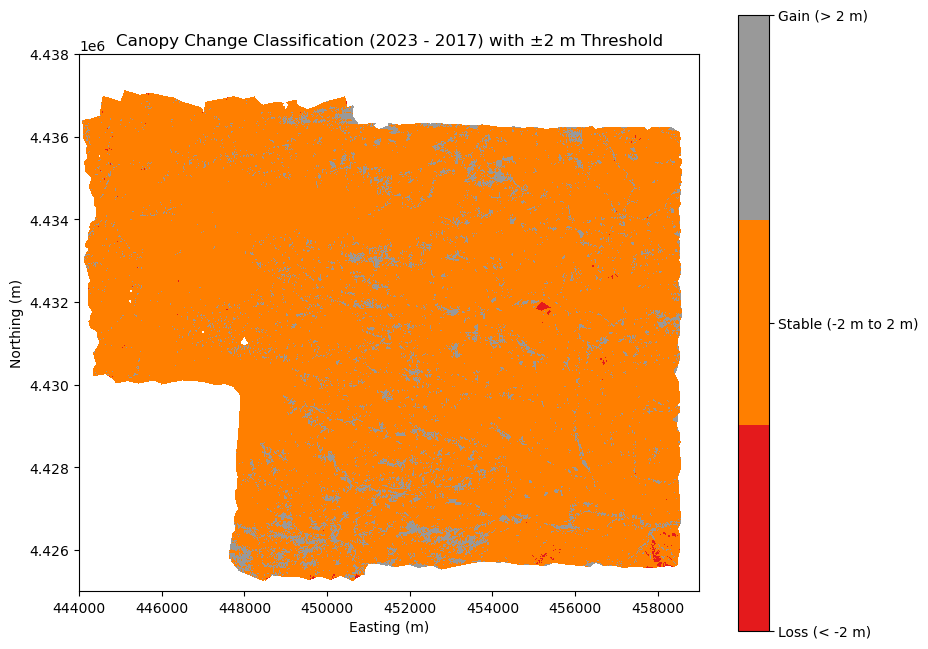

In [43]:
# Define thresholds for change classification:
#   Loss: difference < -2 m
#   Stable: between -2 and 2 m (inclusive)
#   Gain: difference > 2 m
change_class = np.full(diff_data.shape, np.nan)

# Only process valid pixels (diff_data != -9999)
mask_valid = diff_data != -9999

change_class[mask_valid & (diff_data < -2)] = 0   # Canopy loss
change_class[mask_valid & (diff_data >= -2) & (diff_data <= 2)] = 1  # Stable canopy
change_class[mask_valid & (diff_data > 2)] = 2   # Canopy gain

# Visualize the classified change map
plt.figure(figsize=(10, 8))
# Use a discrete colormap with 3 classes
cmap = plt.get_cmap("Set1", 3)
im = plt.imshow(change_class, extent=extent, cmap=cmap, origin="upper")
plt.title("Canopy Change Classification (2023 - 2017) with ±2 m Threshold")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
cbar = plt.colorbar(im, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(["Loss (< -2 m)", "Stable (-2 m to 2 m)", "Gain (> 2 m)"])
plt.show()

### Canopy Change Classification (2023 – 2017)

In this classification map:
- **Orange (Stable)** areas dominate, suggesting that most of the canopy experienced minimal height change (within ±1 m).  
- **Gray (Gain)** regions show where canopy has grown more than 1 m. These patches can reflect genuine regrowth or artifactually high values and merit closer inspection.  
- **Red (Loss)** spots indicate where the canopy has decreased by more than 1 m, potentially reflecting disturbances such as harvest, fire, or disease.

Overall, the map highlights that the majority of the area remained relatively stable, with scattered pockets of both canopy gain and loss.

### Visualization of Labeled Canopy Gain Patches

Contiguous regions of canopy gain are identified by labeling areas where the change classification indicates gain (i.e., values equal to 2). Each connected patch is assigned a unique ID, and the total number of gain patches is printed. The labeled patches are then visualized using a color-coded plot, with a colorbar indicating the patch IDs. This visualization helps to assess the spatial distribution and fragmentation of canopy growth regions.


Number of gain patches: 4856048


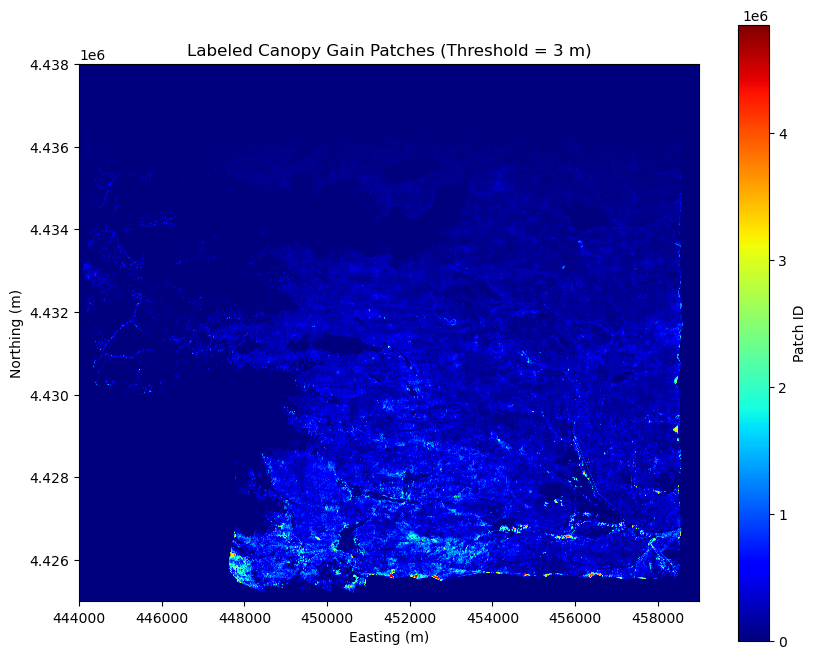

In [46]:
# Create an empty classification array with the same shape as diff_data using float32 to reduce memory usage.
change_class = np.full(diff_data.shape, np.nan, dtype=np.float32)

# Create a mask for valid pixels (i.e., those not equal to the nodata value).
mask_valid = diff_data != -9999.0

# Define classes using the new thresholds:
#   Loss: diff < -3 m
#   Stable: -3 m <= diff <= 3 m
#   Gain: diff > 3 m
change_class[mask_valid & (diff_data < -3)] = 0  # Canopy loss
change_class[mask_valid & (diff_data >= -3) & (diff_data <= 3)] = 1  # Stable canopy
change_class[mask_valid & (diff_data > 3)] = 2  # Canopy gain

# Label contiguous regions of canopy gain (i.e. where change_class == 2)
from scipy.ndimage import label
gain_mask = (change_class == 2)
labeled_gain, num_features = label(gain_mask)
print(f"Number of gain patches: {num_features}")

# Visualize the labeled gain patches
plt.figure(figsize=(10, 8))
plt.imshow(labeled_gain, extent=extent, cmap="jet", origin="upper")
plt.title("Labeled Canopy Gain Patches (Threshold = 3 m)")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="Patch ID")
plt.show()

### Analysis of Labeled Canopy Gain Patches

The analysis now detected 6,254,611 gain patches. This very high number indicates that many of the contiguous gain areas are very small, likely reflecting minor variations or noise rather than substantial canopy recovery. Further analysis, such as assessing the distribution of patch sizes or aggregating patches below a certain area threshold, is needed to determine which changes are ecologically significant.


Number of gain patches larger than 50 m²: 5464


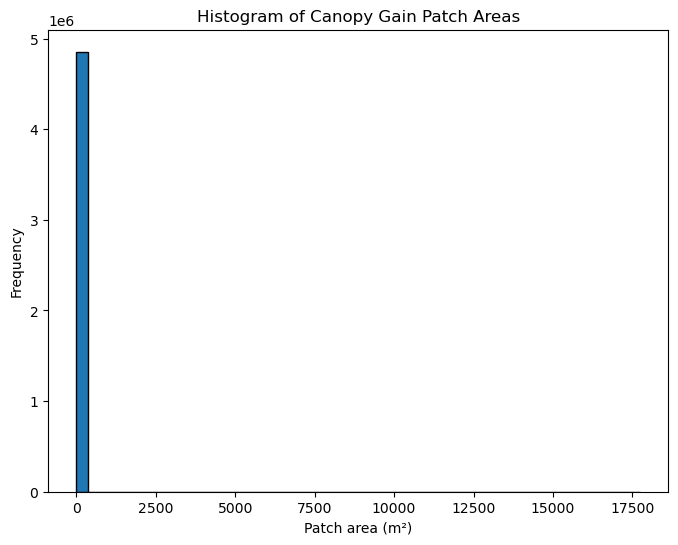

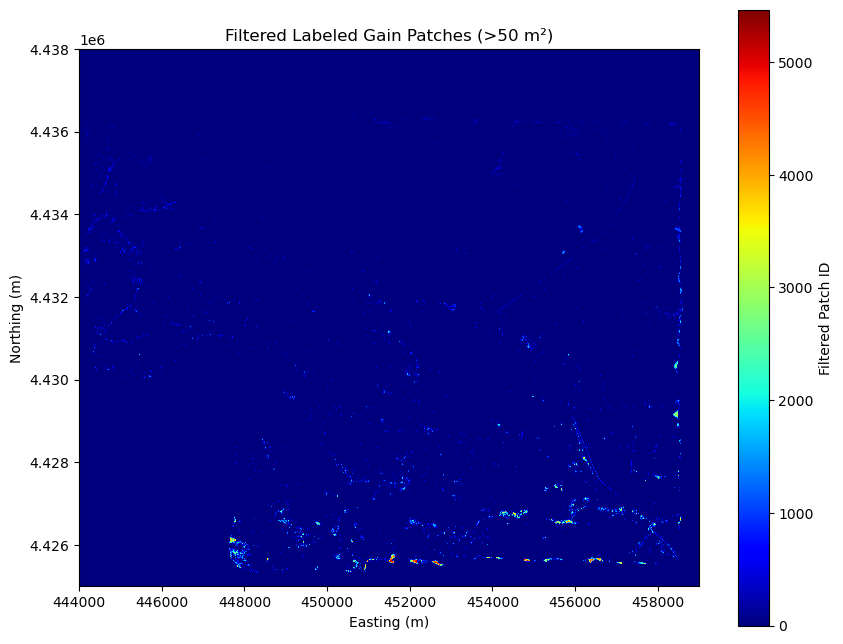

In [67]:
from scipy.ndimage import label, sum as ndi_sum

# Assume 'labeled_gain' is the output from the earlier labeling of gain pixels,
# and each pixel corresponds to 1 m².
pixel_area = 1.0  # 1 m² per pixel

# Calculate the area (in m²) of each gain patch (excluding background label 0)
patch_areas = ndi_sum(np.ones_like(labeled_gain), labeled_gain, index=np.arange(1, num_features+1))
patch_areas = np.array(patch_areas) * pixel_area

# Define a threshold (in m²) below which patches are considered noise.
threshold_area = 50  # e.g., only keep patches larger than 50 m²

# Create a mask for patches that are larger than the threshold.
large_patch_mask = patch_areas >= threshold_area

# Build a new labeled array that only retains large patches.
filtered_labeled_gain = np.zeros_like(labeled_gain)
new_patch_id = 1
for i, is_large in enumerate(large_patch_mask, start=1):
    if is_large:
        filtered_labeled_gain[labeled_gain == i] = new_patch_id
        new_patch_id += 1

num_large_patches = new_patch_id - 1
print(f"Number of gain patches larger than {threshold_area} m²: {num_large_patches}")

# Plot a histogram of patch areas to examine their distribution.
plt.figure(figsize=(8, 6))
plt.hist(patch_areas, bins=50, edgecolor="k")
plt.xlabel("Patch area (m²)")
plt.ylabel("Frequency")
plt.title("Histogram of Canopy Gain Patch Areas")
plt.show()

# Visualize the filtered gain patches map.
plt.figure(figsize=(10, 8))
plt.imshow(filtered_labeled_gain, extent=extent, cmap="jet", origin="upper")
plt.title(f"Filtered Labeled Gain Patches (>{threshold_area} m²)")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="Filtered Patch ID")
plt.show()

In [49]:
hjik
===

SyntaxError: invalid syntax (1398462235.py, line 2)

In [69]:
import psutil

# Get the current process
process = psutil.Process()
# Get the memory usage in bytes
memory_usage = process.memory_info().rss  # in bytes

# Convert to more convenient units, like MB
memory_usage_mb = memory_usage / (1024 ** 2)
print(f"Current memory usage: {memory_usage_mb:.2f} MB")

Current memory usage: 3716.15 MB


In [ ]:
import gc

# Delete any large arrays you don't need anymore
del diff_data  # if you're done with it
# ... delete other large objects if needed

# Force garbage collection
gc.collect()

In [ ]:
summary_df.head()

In [ ]:
import os
import rasterio
from rasterio.merge import merge

# Define root and output folders
folder_path = "C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II/NEON_NIWO_chmdata"
output_dir = os.path.join(folder_path, "mosaics")
os.makedirs(output_dir, exist_ok=True)

# Get list of subfolders that look like years
year_folders = [name for name in os.listdir(folder_path)
                if os.path.isdir(os.path.join(folder_path, name)) and name.isdigit()]

for year in sorted(year_folders):
    year_folder = os.path.join(folder_path, year)
    tif_files = [os.path.join(year_folder, f) for f in os.listdir(year_folder) if f.endswith(".tif")]

    if not tif_files:
        print(f"⚠️ No TIFFs found in {year}, skipping...")
        continue

    print(f"🛠 Creating mosaic for {year} with {len(tif_files)} files...")

    # Open all the TIFFs
    src_files_to_mosaic = [rasterio.open(fp) for fp in tif_files]
    mosaic, out_trans = merge(src_files_to_mosaic)

    # Use metadata from first file
    out_meta = src_files_to_mosaic[0].meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
        "compress": "lzw"
    })

    # Save mosaic
    output_fp = os.path.join(output_dir, f"NIWO_CHM_{year}.tif")
    with rasterio.open(output_fp, "w", **out_meta) as dest:
        dest.write(mosaic)

    print(f"✅ Mosaic for {year} saved: {output_fp}")

In [ ]:
import os
import time
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.windows import from_bounds
from tqdm import tqdm

# === CONFIG ===
folder_path = r"C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\NEON_NIWO_chmdata"
output_dir = os.path.join(folder_path, "mosaics")
os.makedirs(output_dir, exist_ok=True)
ref_year = "2023"
ref_mosaic_path = os.path.join(output_dir, f"NIWO_CHM_{ref_year}.tif")

# === Load Reference Profile ===
with rasterio.open(ref_mosaic_path) as ref:
    ref_profile = ref.profile
    ref_crs = ref.crs
    ref_transform = ref.transform
    ref_shape = ref.shape
    ref_dtype = ref_profile["dtype"]
    ref_nodata = ref_profile.get("nodata", -9999)

ref_profile.update({
    "driver": "GTiff",
    "tiled": True,
    "blockxsize": 512,
    "blockysize": 512,
    "compress": "lzw",
    "count": 1,
    "nodata": ref_nodata
})

# === Logger ===
def log(msg): print(f"[{time.strftime('%H:%M:%S')}] {msg}")

# === Year folders ===
year_folders = sorted([
    f for f in os.listdir(folder_path)
    if os.path.isdir(os.path.join(folder_path, f)) and f.isdigit()
])

# === Process Each Year ===
for year in year_folders:
    tif_files = [
        os.path.join(folder_path, year, f)
        for f in os.listdir(os.path.join(folder_path, year)) if f.endswith(".tif")
    ]
    if not tif_files:
        log(f"⚠️ No TIFFs found in {year}, skipping.")
        continue

    output_fp = os.path.join(output_dir, f"NIWO_CHM_{year}.tif")
    log(f"🛠 Creating mosaic for {year} using reference grid...")
    start = time.time()

    with rasterio.open(output_fp, "w", **ref_profile) as dst:
        for src_fp in tqdm(tif_files, desc=f"Aligning {year}", unit="tile"):
            with rasterio.open(src_fp) as src:
                src_data = src.read(1)
                aligned = np.full(ref_shape, ref_nodata, dtype=ref_dtype)

                reproject(
                    source=src_data,
                    destination=aligned,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=ref_transform,
                    dst_crs=ref_crs,
                    resampling=Resampling.bilinear,
                    src_nodata=src.nodata,
                    dst_nodata=ref_nodata
                )

                # Mask nodata and write non-nodata to window
                valid_mask = aligned != ref_nodata
                if np.any(valid_mask):
                    bounds = src.bounds
                    window = from_bounds(*bounds, transform=ref_transform)
                    window = window.round_offsets().round_lengths()

                    window_data = aligned[
                        window.row_off:window.row_off + window.height,
                        window.col_off:window.col_off + window.width
                    ]
                    dst.write(window_data, 1, window=window)

    elapsed = time.time() - start
    log(f"✅ Mosaic for {year} written to disk in {elapsed:.1f}s → {output_fp}")

In [ ]:
total_pixels = chm_2017.size
valid_pixels = np.count_nonzero(~mask)
print(f"Valid pixels: {valid_pixels} / {total_pixels} ({100 * valid_pixels / total_pixels:.4f}%)")

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

window_size = 1000  # try 1000x1000 pixels
start_row, start_col = 5000, 5000  # somewhere near the center

with rasterio.open(mosaic_2017) as src:
    window = rasterio.windows.Window(start_col, start_row, window_size, window_size)
    data = src.read(1, window=window)
    nodata = src.nodata

masked = np.where(data == nodata, np.nan, data)

plt.figure(figsize=(8, 6))
plt.imshow(masked, cmap="Greens")
plt.title("Sample CHM 2017 Patch")
plt.colorbar(label="Canopy Height (m)")
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Already loaded earlier:
# chm_2017, chm_2023

both_valid = (~mask) & (chm_2017 > 0) & (chm_2023 > 0)
print(f"Pixels with valid data in both years: {np.count_nonzero(both_valid)}")

In [ ]:
import os
import rasterio
import numpy as np
import pandas as pd

# Paths
mosaic_dir = r"C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\NEON_NIWO_chmdata\mosaics"
ref_year = "2023"
ref_path = os.path.join(mosaic_dir, f"NIWO_CHM_{ref_year}.tif")

# Load reference once
with rasterio.open(ref_path) as ref_src:
    ref_data = ref_src.read(1)
    ref_nodata = ref_src.nodata

# Function to check overlap
def check_overlap_stats(compare_path):
    with rasterio.open(compare_path) as src:
        data = src.read(1)
        nodata = src.nodata

        # Valid mask
        mask = (data <= 1) | (data == nodata) | (ref_data == ref_nodata)
        change = np.where(mask, np.nan, ref_data - data)
        valid_pixels = np.count_nonzero(~np.isnan(change))
        total_pixels = change.size
        return valid_pixels, total_pixels

# Loop through mosaic files
results = []

for fname in sorted(os.listdir(mosaic_dir)):
    if fname.endswith(".tif") and ref_year not in fname:
        year = fname.split("_")[-1].split(".")[0]
        path = os.path.join(mosaic_dir, fname)
        valid, total = check_overlap_stats(path)
        percent = 100 * valid / total
        results.append({
            "Year": year,
            "ValidPixels": valid,
            "TotalPixels": total,
            "PercentOverlap": percent
        })
        print(f"📅 {year} — Valid Pixels: {valid:,} ({percent:.2f}%)")

# Convert to DataFrame
overlap_df = pd.DataFrame(results)
overlap_df = overlap_df.sort_values("Year")
overlap_df


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Paths to your mosaic files
mosaic_2017 = "C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II/NEON_NIWO_chmdata/mosaics/NIWO_CHM_2017.tif"
mosaic_2023 = "C:/Users/macfr/OneDrive/Documents/MSDS/MSDS 696_Practicum II/NEON_NIWO_chmdata/mosaics/NIWO_CHM_2023.tif"

with rasterio.open(mosaic_2017) as src1, rasterio.open(mosaic_2023) as src2:
    if src1.crs != src2.crs or src1.transform != src2.transform:
        raise ValueError("❌ Mosaics are not aligned!")
    
    chm_2017 = src1.read(1)
    chm_2023 = src2.read(1)
    profile = src1.profile

# Mask no-data or low height (<1m)
mask = (chm_2017 <= 1) | (chm_2017 == src1.nodata) | (chm_2023 == src2.nodata)
change = np.where(mask, np.nan, chm_2023 - chm_2017)

# Plot
plt.figure(figsize=(10, 6))
plt.imshow(change, cmap='RdYlGn', vmin=-5, vmax=5)
plt.colorbar(label='Canopy Height Change (m)')
plt.title("Canopy Height Change (2023 - 2017)")
plt.axis("off")
plt.show()

In [ ]:
print("Valid pixels in change array:", np.count_nonzero(~np.isnan(change)))

In [ ]:
print("src1.nodata:", src1.nodata)
print("src2.nodata:", src2.nodata)

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

mosaic_2017 = r"C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\NEON_NIWO_chmdata\mosaics\NIWO_CHM_2017.tif"
mosaic_2023 = r"C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\NEON_NIWO_chmdata\mosaics\NIWO_CHM_2023.tif"

with rasterio.open(mosaic_2017) as src1, rasterio.open(mosaic_2023) as src2:
    if src1.crs != src2.crs or src1.transform != src2.transform:
        raise ValueError("❌ Mosaics are not aligned!")

    chm_2017 = src1.read(1).astype("float32")
    chm_2023 = src2.read(1).astype("float32")
    nodata_1 = src1.nodata if src1.nodata is not None else -9999
    nodata_2 = src2.nodata if src2.nodata is not None else -9999

# Debug info
print("Valid range 2017:", np.nanmin(chm_2017), np.nanmax(chm_2017))
print("Valid range 2023:", np.nanmin(chm_2023), np.nanmax(chm_2023))

# Mask invalid pixels
mask = (chm_2017 <= 1) | (chm_2017 == nodata_1) | (chm_2023 == nodata_2)
change = np.where(mask, np.nan, chm_2023 - chm_2017)

# Confirm there's something to plot
print("Valid pixels in change image:", np.count_nonzero(~np.isnan(change)))

# Plot
plt.figure(figsize=(10, 6))
plt.imshow(change, cmap='RdYlGn', vmin=-5, vmax=5)
plt.colorbar(label='Canopy Height Change (m)')
plt.title("Canopy Height Change (2023 - 2017)")
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Get indices of valid data
valid_indices = np.argwhere(~np.isnan(change))

# Center around a valid point
if valid_indices.size > 0:
    y, x = valid_indices[len(valid_indices) // 2]
    window_size = 200

    ymin = max(0, y - window_size)
    ymax = min(change.shape[0], y + window_size)
    xmin = max(0, x - window_size)
    xmax = min(change.shape[1], x + window_size)

    plt.figure(figsize=(8, 6))
    plt.imshow(change[ymin:ymax, xmin:xmax], cmap="RdYlGn", vmin=-5, vmax=5)
    plt.colorbar(label="Canopy Height Change (m)")
    plt.title("Zoomed In: Canopy Height Change")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No valid data found to zoom into.")

In [ ]:
print("Valid pixels in change array:", np.count_nonzero(~np.isnan(change)))

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Input paths
mosaic_dir = r"C:\Users\macfr\OneDrive\Documents\MSDS\MSDS 696_Practicum II\NEON_NIWO_chmdata\mosaics"
tif_2017 = os.path.join(mosaic_dir, "NIWO_CHM_2017.tif")
tif_2023 = os.path.join(mosaic_dir, "NIWO_CHM_2023.tif")

with rasterio.open(tif_2017) as src_17, rasterio.open(tif_2023) as src_23:
    chm_2017 = src_17.read(1).astype("float32")
    chm_2023 = src_23.read(1).astype("float32")
    nodata = src_17.nodata

# Mask nodata and low canopy (< 1m)
mask = (chm_2017 == nodata) | (chm_2023 == nodata) | (chm_2017 < 1)
change = np.where(mask, np.nan, chm_2023 - chm_2017)

# Quick stats
print("🌲 Canopy Height Change (2023 - 2017):")
print(f"  ➕ Max Gain: {np.nanmax(change):.2f} m")
print(f"  ➖ Max Loss: {np.nanmin(change):.2f} m")
print(f"  📊 Mean Change: {np.nanmean(change):.2f} m")

# Visualization
plt.figure(figsize=(10, 6))
plt.imshow(change, cmap="RdYlGn", vmin=-10, vmax=10)
plt.colorbar(label="Height Change (m)")
plt.title("Canopy Height Change: 2023 - 2017")
plt.axis("off")
plt.tight_layout()
plt.show()
